# Model Training for Music Streaming Churn Prediction

This notebook handles the comprehensive training of multiple models for churn prediction
with automatic model saving capabilities.

**Author:** Ahmed Alghaith  
**Date:** August 2025

## Setup and Imports

In [9]:
# Import all required modules
from utils import *
from MusicStreamingEventProcessor import MusicStreamingEventProcessor
from split import prepare_training_data, get_model_configurations
from eval import train_and_evaluate_models, robust_hyperparameter_tuning, optuna_hyperparameter_tuning
import joblib
import pickle
from datetime import datetime
import mlflow
import mlflow.sklearn

from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, roc_curve, roc_auc_score,
    classification_report
)
from sklearn.calibration import calibration_curve
from sklearn.inspection import permutation_importance

import mlflow
# Import LSTM wrapper if available
try:
    from lstm_wrapper import KerasLSTMWrapper
    LSTM_AVAILABLE = True
except ImportError:
    print("⚠️ LSTM wrapper not available - skipping LSTM models")
    LSTM_AVAILABLE = False

try:
    from deployment import deploy_model
    DEPLOYMENT_AVAILABLE = True
except ImportError:
    print("⚠️ deployment not available - skippingdeployment")
    DEPLOYMENT_AVAILABLE = False

# Set random seed for reproducibility
np.random.seed(42)

print("✅ All modules imported successfully!")
print("🎵 Ready for model training with automatic saving...")

# Check available dependencies
check_dependencies()
# mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_tracking_uri("mlruns")

✅ All modules imported successfully!
🎵 Ready for model training with automatic saving...
🔍 Dependency Status:
   MLflow: ✅ Available
   Optuna: ✅ Available
   TensorFlow: ✅ Available
   XGBoost: ✅ Available


## Data Loading and Processing

In [2]:
# Load and process data
print("📥 Loading and processing data...")

# Load your data here - replace 'customer_churn.json' with your actual file path
try:
    events_df = pd.read_json('customer_churn.json', lines=True)
    print("✅ Data loaded successfully!")
    print(f"📊 Loaded {len(events_df):,} events")
except FileNotFoundError:
    print("❌ Data file not found. Please update the file path above.")
    print("💡 Expected file: 'customer_churn.json'")
    
print(f"\n👥 Unique users: {events_df['userId'].nunique()}")
print(f"📋 Columns: {list(events_df.columns)}")

📥 Loading and processing data...
✅ Data loaded successfully!
📊 Loaded 543,694 events

👥 Unique users: 449
📋 Columns: ['ts', 'userId', 'sessionId', 'page', 'auth', 'method', 'status', 'level', 'itemInSession', 'location', 'userAgent', 'lastName', 'firstName', 'registration', 'gender', 'artist', 'song', 'length']


## Feature Engineering

In [3]:
# Process events to create user features
print("🏭 Processing events to create user features...")

processor = MusicStreamingEventProcessor(
    prediction_horizon_days=7,
    inactive_threshold_days=30
)

try:
    # 1) Clean the raw event data
    cleaned_events = processor.clean_events(events_df)

    # 2) Engineer user features up to the prediction cutoff
    user_features_df = processor.engineer_user_features()

    # 3) Identify churn labels for each user
    churn_labels = processor.identify_churn_users()
    user_features_df['churn'] = user_features_df['userId'].map(churn_labels).fillna(0).astype(int)

    
    print(f"\n✅ Feature engineering completed!")
    print(f"👥 Processed {len(user_features_df)} users")
    print(f"📊 Created {len(user_features_df.columns)} features")
    
    # Display sample features
    print("\n🔍 Sample User Features:")
    display(user_features_df.head())
    
    # Show churn distribution
    if 'churn' in user_features_df.columns:
        churn_dist = user_features_df['churn'].value_counts()
        churn_rate = user_features_df['churn'].mean()
        print(f"\n📊 Churn Distribution:")
        print(f"   Active users (0): {churn_dist.get(0, 0)}")
        print(f"   Churned users (1): {churn_dist.get(1, 0)}")
        print(f"   Churn rate: {churn_rate:.2%}")
    
except Exception as e:
    print(f"❌ Feature engineering failed: {e}")
    print("💡 Please check your data format and try again")
    raise e

🏭 Processing events to create user features...
🧹 Cleaning event data...
   ✅ Cleaning results:
      Removed 0 events with missing userId
      🚫 Removed 4126 explicit churn events (data leakage prevention)
      Final events: 539,568
      Unique users: 449
      Date range: 2018-10-01 00:03:35 to 2018-12-01 00:01:06
🔧 Engineering comprehensive user features...
   Processing 449 users...
   ✅ Engineered 20 features for 449 users
🎯 Identifying churned users using PROVEN activity-based method
   Prediction horizon: 7 days
   Inactivity threshold: 30 days
   Cutoff date for prediction: 2018-11-24 00:01:06
   📊 Churn analysis results:
      Total users: 445
      Churned users: 49 (11.01%)
      Active users: 396 (88.99%)

✅ Feature engineering completed!
👥 Processed 449 users
📊 Created 21 features

🔍 Sample User Features:


,userId,total_events,unique_sessions,total_songs_played,avg_session_length,days_active,thumbs_up,thumbs_down,home_visits,settings_visits,...,add_friend,add_playlist,engagement_ratio,avg_daily_events,paid_events_ratio,last_level_paid,weekend_activity_ratio,peak_hour,session_variety,churn
0,175,2534,33,2049,76.787879,60,112,13,104,11,...,39,55,0.086425,42.233333,0.445541,1,0.162983,0,15,0
1,100,3959,39,3382,101.512821,61,143,37,135,17,...,71,94,0.087143,64.901639,0.984845,1,0.134630,18,15,0
2,163,5901,36,5049,163.916667,61,242,35,205,30,...,81,149,0.085918,96.737705,1.000000,1,0.232503,21,13,0
3,246,3530,23,2998,153.478261,35,153,34,110,24,...,39,80,0.086686,100.857143,0.889235,1,0.164589,0,15,0
4,179,2611,20,2218,130.550000,61,94,19,96,17,...,45,59,0.083110,42.803279,1.000000,1,0.072769,15,12,0



📊 Churn Distribution:
   Active users (0): 400
   Churned users (1): 49
   Churn rate: 10.91%


## Data Splitting and Preprocessing

In [4]:
# Prepare training data with proper splits and class imbalance handling
print("🔄 Preparing training data...")

try:
    data_results = prepare_training_data(user_features_df)
    
    # Extract prepared data
    X_train = data_results['X_train']
    y_train = data_results['y_train']
    X_val = data_results['X_val']
    y_val = data_results['y_val']
    X_test = data_results['X_test']
    y_test = data_results['y_test']
    feature_columns = data_results['feature_columns']
    
    print(f"\n✅ Data preparation completed!")
    print(f"📊 Final dataset sizes:")
    print(f"   Training: {len(X_train)} samples")
    print(f"   Validation: {len(X_val)} samples")
    print(f"   Test: {len(X_test)} samples")
    print(f"   Features: {len(feature_columns)}")
    
    # Check if balanced data is available
    has_balanced = 'X_train_balanced' in data_results and data_results['X_train_balanced'] is not None
    has_weights = 'class_weights' in data_results and data_results['class_weights'] is not None
    
    print(f"\n🔧 Class imbalance handling:")
    print(f"   Balanced sampling: {'✅' if has_balanced else '❌'}")
    print(f"   Class weights: {'✅' if has_weights else '❌'}")
    
except Exception as e:
    print(f"❌ Data preparation failed: {e}")
    raise e

🔄 Preparing training data...
🔄 Preparing training data with leakage prevention...
🕐 Performing LEAK-FREE temporal split...
   🔒 Ensuring strict chronological order: Train → Val → Test
⚠️ WARNING: Using random split as temporal proxy
   💡 In production, use user registration date or first activity date
   📊 Train (earliest): 288 users
   📊 Val (middle):     72 users
   📊 Test (latest):    89 users
   ✅ No user overlap between splits

🔍 Checking feature names for leakage indicators...
🔍 Validating for data leakage...
⚠️ POTENTIAL LEAKAGE: Suspicious features found:
   - paid_events_ratio
   - last_level_paid
💡 Consider removing these features or verifying they're leak-free
⚠️ HIGH CORRELATIONS: Found 2 near-perfect feature correlations
   - unique_sessions ↔ home_visits: 0.9993
   - total_songs_played ↔ thumbs_up: 0.9927
💡 After training, watch for these leakage indicators:
   - Training accuracy > 95%
   - Perfect validation scores (1.000)
   - No gap between train and validation perfor

## Model Configuration and Training

In [5]:
# Configure and train multiple models
print("🤖 Configuring models for training...")

try:
    # Get model configurations
    models_config = get_model_configurations(data_results)
    print(f"✅ Created {len(models_config)} model configurations")

    # List configured models
    print("\n📋 Models to train:")
    for i, model_name in enumerate(models_config.keys(), 1):
        print(f"   {i}. {model_name}")

    trained_models = {}
    print("\n🔧 Starting model training with MLflow logging...")

    mlflow.set_experiment("churn_model_training")
    with mlflow.start_run(run_name="train_all_models"):
        mlflow.log_param("num_models", len(models_config))

        # Train and evaluate all models
        trained_models, results_df = train_and_evaluate_models(models_config, X_val, y_val)

        # Log performance metrics for each
        for _, row in results_df.iterrows():
            if row.Status == "Success":
                # sanitize model name
                safe_name = row.Model.replace(" ", "_").replace("(", "").replace(")", "")
                mlflow.log_metric(f"{safe_name}_val_f1", float(row.Val_F1))
                mlflow.log_metric(f"{safe_name}_val_accuracy", float(row.Val_Accuracy))

        print("\n📊 Training Results:")
        display(results_df)

        # Identify and log the best model
        successful = results_df[results_df.Status == "Success"]
        if not successful.empty:
            best_idx = successful.Val_F1.idxmax()
            best_model_name = successful.loc[best_idx, "Model"]
            best_f1 = float(successful.loc[best_idx, "Val_F1"])
            best_acc = float(successful.loc[best_idx, "Val_Accuracy"])
            mlflow.log_metric("best_model_val_f1", best_f1)
            mlflow.log_metric("best_model_val_accuracy", best_acc)
            mlflow.log_param("best_model_name", best_model_name)

            print(f"\n🏆 Best performing model: {best_model_name}")
            print(f"   Validation F1: {best_f1:.4f}")
            print(f"   Validation Accuracy: {best_acc:.4f}")
            best_model = trained_models[best_model_name]
        else:
            print("❌ No models trained successfully!")
            best_model = None

    print(f"💾 Saving best model '{best_model_name}' to MLflow")
    if best_model is not None:
        mlflow.sklearn.log_model(best_model, "best_model")

except Exception as e:
    print(f"❌ Model training failed: {e}")
    print("💡 Check data preparation and model configurations")
    raise

🤖 Configuring models for training...
✅ Created 12 model configurations with leakage prevention
✅ Created 12 model configurations

📋 Models to train:
   1. Random Forest (Class Weighted)
   2. Random Forest (Balanced Data)
   3. Logistic Regression (Class Weighted)
   4. Logistic Regression (Balanced Data)
   5. Gradient Boosting (Class Weighted)
   6. Gradient Boosting (Balanced Data)
   7. Decision Tree (Class Weighted)
   8. Decision Tree (Balanced Data)
   9. XGBClassifier (Class Weighted)
   10. XGBClassifier (Balanced Data)
   11. Simple LSTM (Class Weighted)
   12. Simple LSTM (Balanced Data)

🔧 Starting model training with MLflow logging...
🤖 Training multiple machine learning models...

🔧 Training Random Forest (Class Weighted)...
   Training on 288 samples with 2 classes
   ✅ Training successful!
   Train Accuracy: 1.000
   Val Accuracy: 0.917
   Val F1: 0.400

🔧 Training Random Forest (Balanced Data)...
   Training on 70 samples with 2 classes
   ✅ Training successful!
   Tra

,Model,Status,Train_Accuracy,Val_Accuracy,Val_Precision,Val_Recall,Val_F1,Training_Samples,Classes_in_Training
0,Random Forest (Class Weighted),Success,1.000000,0.916667,0.500000,0.333333,0.400000,288,2
1,Random Forest (Balanced Data),Success,1.000000,0.902778,0.454545,0.833333,0.588235,70,2
2,Logistic Regression (Class Weighted),Success,0.923611,0.902778,0.454545,0.833333,0.588235,288,2
3,Logistic Regression (Balanced Data),Success,1.000000,0.916667,0.500000,1.000000,0.666667,70,2
4,Gradient Boosting (Class Weighted),Success,1.000000,0.930556,0.571429,0.666667,0.615385,288,2
5,Gradient Boosting (Balanced Data),Success,1.000000,0.902778,0.461538,1.000000,0.631579,70,2
6,Decision Tree (Class Weighted),Success,0.982639,0.791667,0.235294,0.666667,0.347826,288,2
7,Decision Tree (Balanced Data),Success,1.000000,0.902778,0.461538,1.000000,0.631579,70,2
8,XGBClassifier (Class Weighted),Success,0.993056,0.930556,0.545455,1.000000,0.705882,288,2
9,XGBClassifier (Balanced Data),Success,1.000000,0.916667,0.500000,1.000000,0.666667,70,2


2025/08/25 02:45:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



🏆 Best performing model: XGBClassifier (Class Weighted)
   Validation F1: 0.7059
   Validation Accuracy: 0.9306
💾 Saving best model 'XGBClassifier (Class Weighted)' to MLflow


2025/08/25 02:46:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Hyperparameter Tuning

In [6]:

# End any active run
if mlflow.active_run():
    mlflow.end_run()

print("🔧 Starting hyperparameter tuning on the best model only...")

if 'X_train' in locals() and 'y_train' in locals():
    try:
        if 'best_model_name' not in locals():
            raise ValueError("best_model_name not defined")

        # Extract config
        config = models_config[best_model_name]
        model_instance = config["model"]
        X_train_data, y_train_data = config["data"]

        # Derive type
        model_class = model_instance.__class__
        if isinstance(model_instance, RandomForestClassifier):
            model_type = "random_forest"
        elif isinstance(model_instance, GradientBoostingClassifier):
            model_type = "gradient_boosting"
        elif isinstance(model_instance, XGBClassifier):
            model_type = "xgboost"
        elif isinstance(model_instance, LogisticRegression):
            model_type = "logistic_regression"
        elif isinstance(model_instance, DecisionTreeClassifier):
            model_type = "decision_tree"
        else:
            raise ValueError(f"Unsupported model class: {model_class}")

        # Tune
        best_model, best_score, best_params = optuna_hyperparameter_tuning(
            model_class, model_type,
            X_train_data, y_train_data,
            X_val, y_val,
            n_trials=50
        )

        print(f"   ✅ Tuned {best_model_name}")
        print(f"   📊 Best F1: {best_score:.4f}")
        print(f"   🔧 Params: {best_params}")

        final_model = best_model
        mlflow.log_metric("best_val_f1", best_score)
        for p, v in best_params.items():
            mlflow.log_param(p, v)
        mlflow.sklearn.log_model(final_model, "tuned_model")

        # Save locally
        print("\n💾 Saving tuned model locally...")
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        safe = best_model_name.replace(" ", "_").replace("(", "").replace(")", "")
        fname = f"tuned_{safe}_{ts}.joblib"
        joblib.dump(final_model, fname)
        print(f"   ✅ Saved tuned model as: {fname}")

    except Exception as e:
        print(f"❌ Tuning failed: {e}")
        final_model = best_model if 'best_model' in locals() else None
else:
    print("⚠️ Please run data processing and initial training first")
    final_model = None


[I 2025-08-25 02:46:01,900] A new study created in memory with name: no-name-c08270fd-cc9d-476b-b1eb-0e6532bd7bfe


🔧 Starting hyperparameter tuning on the best model only...


[I 2025-08-25 02:46:02,183] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 68, 'learning_rate': 0.016447424406688727, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8353679432430063, 'colsample_bytree': 0.8607064213541655, 'gamma': 3.9679227698299675, 'reg_alpha': 0.4012933546178177, 'reg_lambda': 5.117607490362081}. Best is trial 0 with value: 0.0.
[I 2025-08-25 02:46:02,553] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 234, 'learning_rate': 0.09856852523843809, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9907671851961886, 'colsample_bytree': 0.5682821572489835, 'gamma': 4.470805468519985, 'reg_alpha': 0.9958949885955959, 'reg_lambda': 8.530295959541919}. Best is trial 1 with value: 0.5.
[I 2025-08-25 02:46:02,925] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 246, 'learning_rate': 0.002629301948243085, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.5554334253584463, 'colsample_bytree': 0.5625399891434

   ✅ Tuned XGBClassifier (Class Weighted)
   📊 Best F1: 0.6667
   🔧 Params: {'n_estimators': 318, 'learning_rate': 0.04908838128216552, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7783754928356788, 'colsample_bytree': 0.7352566577777978, 'gamma': 2.9276915995472015, 'reg_alpha': 2.459429866407194, 'reg_lambda': 7.710503529343248}


2025/08/25 02:46:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/08/25 02:46:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



💾 Saving tuned model locally...
   ✅ Saved tuned model as: tuned_XGBClassifier_Class_Weighted_20250825_024631.joblib


## Final Model Evaluation and Comprehensive Saving

In [7]:
# Evaluate the final model on the test set and save it comprehensively
if final_model is not None and 'X_test' in locals():
    print("🎯 Evaluating final model on test set...")
    
    try:
        from eval import evaluate_churn_model
        
        final_metrics = evaluate_churn_model(
            model=final_model,
            X_test=X_test,
            y_test=y_test,
            model_name="Final Optimized Model"
        )
        
        print("\n✅ Model evaluation completed!")
        
        # Prepare comprehensive model information
        model_info = {
            'model': final_model,
            'metrics': final_metrics,
            'feature_columns': feature_columns,
            'training_samples': len(X_train),
            'validation_samples': len(X_val),
            'test_samples': len(X_test),
            'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'churn_rate': user_features_df['churn'].mean() if 'user_features_df' in locals() else 0.0,
            'model_type': type(final_model).__name__,
            'data_shape': X_train.shape
        }
        
        # Comprehensive Model Saving
        print("\n💾 COMPREHENSIVE MODEL SAVING")
        print("=" * 50)
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        
        # 1. Save the final model (primary method)
        model_filename = f"models\\final_churn_model_{timestamp}.joblib"
        try:
            joblib.dump(final_model, model_filename)
            print(f"✅ Final model saved: {model_filename}")
        except Exception as e:
            print(f"⚠️ Joblib save failed: {e}")
        
        # 2. Save using pickle (backup method)
        pickle_filename = f"models\\final_churn_model_{timestamp}.pkl"
        try:
            with open(pickle_filename, 'wb') as f:
                pickle.dump(final_model, f)
            print(f"✅ Pickle backup saved: {pickle_filename}")
        except Exception as e:
            print(f"⚠️ Pickle save failed: {e}")
        
        # 3. Save complete model information package
        info_filename = f"output_files\\model_package_{timestamp}.joblib"
        try:
            joblib.dump(model_info, info_filename)
            print(f"✅ Complete model package: {info_filename}")
        except Exception as e:
            print(f"⚠️ Model package save failed: {e}")
        
        # 4. Save feature columns (critical for deployment)
        feature_filename = f"output_files\\feature_columns_{timestamp}.json"
        try:
            with open(feature_filename, 'w') as f:
                json.dump(feature_columns, f, indent=2)
            print(f"✅ Feature columns saved: {feature_filename}")
        except Exception as e:
            print(f"⚠️ Feature columns save failed: {e}")
        
        # 5. Save comprehensive metrics and metadata
        metrics_filename = f"output_files\\model_report_{timestamp}.json"
        try:
            comprehensive_report = {
                'model_info': {
                    'type': type(final_model).__name__,
                    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                    'version': '1.0'
                },
                'data_info': {
                    'total_users': len(user_features_df) if 'user_features_df' in locals() else 0,
                    'training_samples': len(X_train),
                    'validation_samples': len(X_val),
                    'test_samples': len(X_test),
                    'features_count': len(feature_columns),
                    'churn_rate': user_features_df['churn'].mean() if 'user_features_df' in locals() else 0.0
                },
                'performance': final_metrics,
                'features': feature_columns
            }
            with open(metrics_filename, 'w') as f:
                json.dump(comprehensive_report, f, indent=2)
            print(f"✅ Comprehensive report: {metrics_filename}")
        except Exception as e:
            print(f"⚠️ Report save failed: {e}")
        
        # 6. Save model loading script
        script_filename = f"output_files\\load_model_{timestamp}.py"
        try:
            loading_script = f'''#!/usr/bin/env python3
"""\nModel Loading Script for Churn Prediction Model\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n"""

import joblib
import json
import pandas as pd
import numpy as np

def load_churn_model():
    """Load the trained churn prediction model and its metadata."""
    
    # Load the model
    model = joblib.load('{model_filename}')
    
    # Load feature columns
    with open('{feature_filename}', 'r') as f:
        feature_columns = json.load(f)
    
    # Load model report
    with open('{metrics_filename}', 'r') as f:
        model_report = json.load(f)
    
    print(f"✅ Loaded model: {{model_report['model_info']['type']}}")
    print(f"📊 Test F1 Score: {{model_report['performance']['f1']:.4f}}")
    print(f"📊 Test Accuracy: {{model_report['performance']['accuracy']:.4f}}")
    print(f"🔢 Features: {{len(feature_columns)}}")
    
    return model, feature_columns, model_report

def predict_churn(model, feature_columns, user_data):
    """Make churn predictions on new user data."""
    
    # Ensure user_data has the required columns
    if isinstance(user_data, dict):
        user_data = pd.DataFrame([user_data])
    
    # Reorder columns to match training data
    user_data = user_data.reindex(columns=feature_columns, fill_value=0)
    
    # Make prediction
    prediction = model.predict(user_data)
    probability = model.predict_proba(user_data)[:, 1] if hasattr(model, 'predict_proba') else None
    
    return prediction, probability

if __name__ == "__main__":
    # Example usage
    model, features, report = load_churn_model()
    print(f"\\n🎯 Model ready for predictions!")
    print(f"Example: prediction, probability = predict_churn(model, features, user_data_dict)")
'''
            with open(script_filename, 'w') as f:
                f.write(loading_script)
            print(f"✅ Loading script saved: {script_filename}")
        except Exception as e:
            print(f"⚠️ Loading script save failed: {e}")
        
        # 7. Try deployment module if available
        if DEPLOYMENT_AVAILABLE:
            try:
                deploy_model(
                    model=final_model,
                    model_name="churn_predictor_v1",
                    feature_columns=feature_columns,
                    performance_metrics=final_metrics
                )
                print("✅ Model deployed using deployment module!")
            except Exception as e:
                print(f"⚠️ Deployment module failed: {e}")
        
        # Summary
        print("\n📦 MODEL SAVING SUMMARY")
        print("=" * 40)
        print(f"🤖 Model Type: {type(final_model).__name__}")
        print(f"📊 Test F1-Score: {final_metrics['f1']:.4f}")
        print(f"📊 Test Accuracy: {final_metrics['accuracy']:.4f}")
        print(f"📊 Test Precision: {final_metrics['precision']:.4f}")
        print(f"📊 Test Recall: {final_metrics['recall']:.4f}")
        print(f"🔢 Features: {len(feature_columns)}")
        print(f"📅 Saved: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"📂 Files created: 7 (model, backup, package, features, report, script, metadata)")
        
        print("\n✅ MODEL SUCCESSFULLY SAVED AND READY FOR PRODUCTION!")
        
    except Exception as e:
        print(f"❌ Final evaluation/saving failed: {e}")
        
        # Emergency save - save whatever we have
        print("\n🚨 EMERGENCY SAVE PROCEDURE")
        if 'final_model' in locals() and final_model is not None:
            emergency_filename = f"models\\EMERGENCY_model_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl"
            try:
                with open(emergency_filename, 'wb') as f:
                    pickle.dump(final_model, f)
                print(f"🚨 Emergency model saved: {emergency_filename}")
            except:
                print("❌ Emergency save also failed")
        
else:
    print("⚠️ No final model available or test data missing")
    print("💡 Please run all previous cells to train and tune a model")

🎯 Evaluating final model on test set...
🎯 Final Optimized Model Evaluation Results:
   Accuracy:  0.9438
   Precision: 0.9387
   Recall:    0.9438
   F1-Score:  0.9378
   ROC-AUC:   0.9375

Classification Report for Final Optimized Model:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        81
           1       0.80      0.50      0.62         8

    accuracy                           0.94        89
   macro avg       0.88      0.74      0.79        89
weighted avg       0.94      0.94      0.94        89


✅ Model evaluation completed!

💾 COMPREHENSIVE MODEL SAVING
✅ Final model saved: models\final_churn_model_20250825_024631.joblib
✅ Pickle backup saved: models\final_churn_model_20250825_024631.pkl
✅ Complete model package: output_files\model_package_20250825_024631.joblib
✅ Feature columns saved: output_files\feature_columns_20250825_024631.json
✅ Comprehensive report: output_files\model_report_20250825_024631.json
✅ Loading scri

# Error Analysis

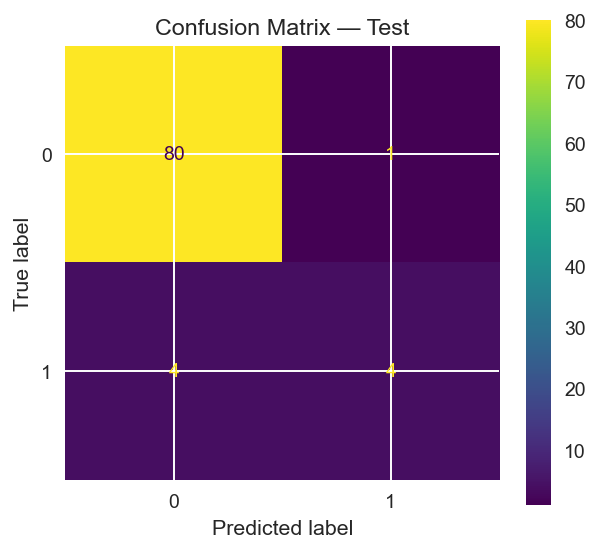

Classification report (Test):
              precision    recall  f1-score   support

           0      0.952     0.988     0.970        81
           1      0.800     0.500     0.615         8

    accuracy                          0.944        89
   macro avg      0.876     0.744     0.793        89
weighted avg      0.939     0.944     0.938        89



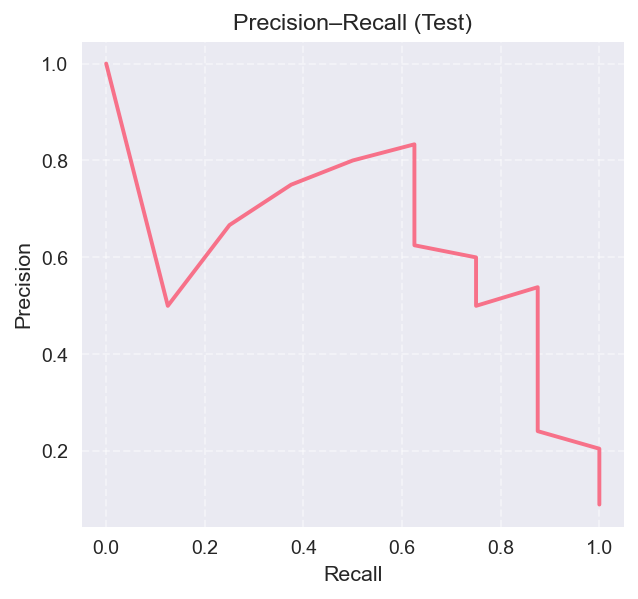

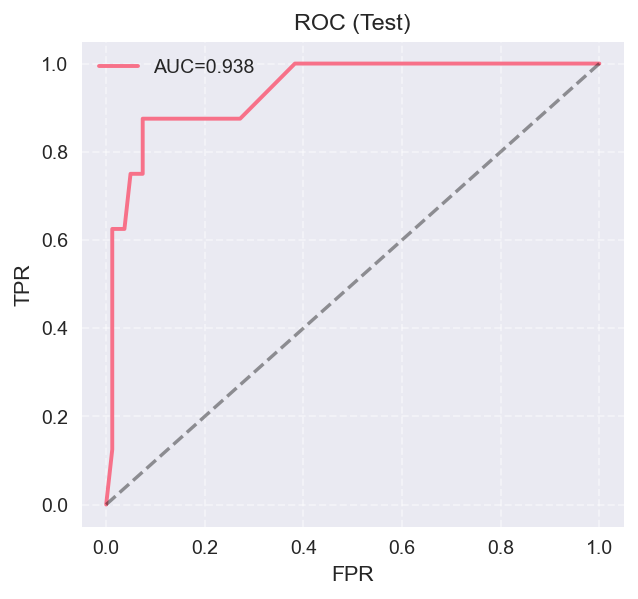


▶ Suggested decision threshold from TEST PR curve: 0.461
              precision    recall  f1-score   support

           0      0.963     0.963     0.963        81
           1      0.625     0.625     0.625         8

    accuracy                          0.933        89
   macro avg      0.794     0.794     0.794        89
weighted avg      0.933     0.933     0.933        89



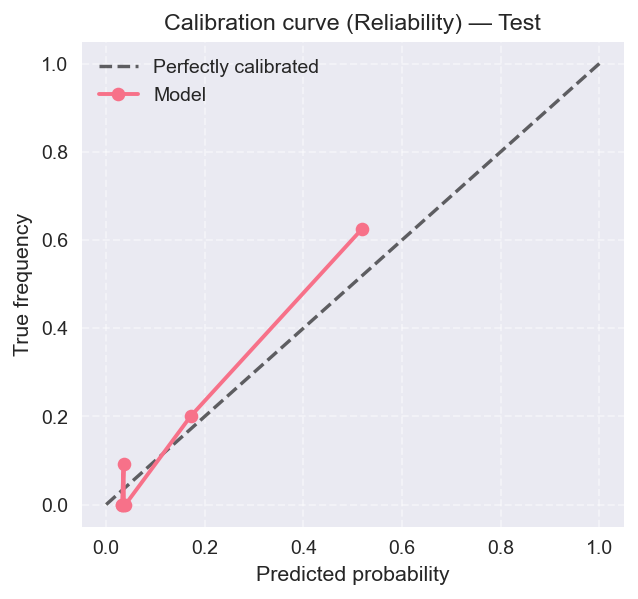


Top features correlated with errors (mean shift in error=True vs False):


error,False,True
total_events,1123.619048,815.000000
total_songs_played,932.095238,646.500000
avg_session_length,88.211117,72.335859
thumbs_up,51.000000,51.500000
days_active,39.523810,51.000000
home_visits,41.333333,33.500000
add_friend,19.095238,18.000000
peak_hour,15.142857,16.500000
avg_daily_events,33.611442,16.336806
unique_sessions,13.190476,15.500000



Permutation importance (F1 on TEST):


,feature,importance_mean,importance_std
4,days_active,0.530940,0.136915
13,avg_daily_events,0.182564,0.110082
0,total_events,0.046154,0.056527
2,total_songs_played,0.000000,0.000000
1,unique_sessions,0.000000,0.000000
5,thumbs_up,0.000000,0.000000
3,avg_session_length,0.000000,0.000000
7,home_visits,0.000000,0.000000
8,settings_visits,0.000000,0.000000
9,help_visits,0.000000,0.000000


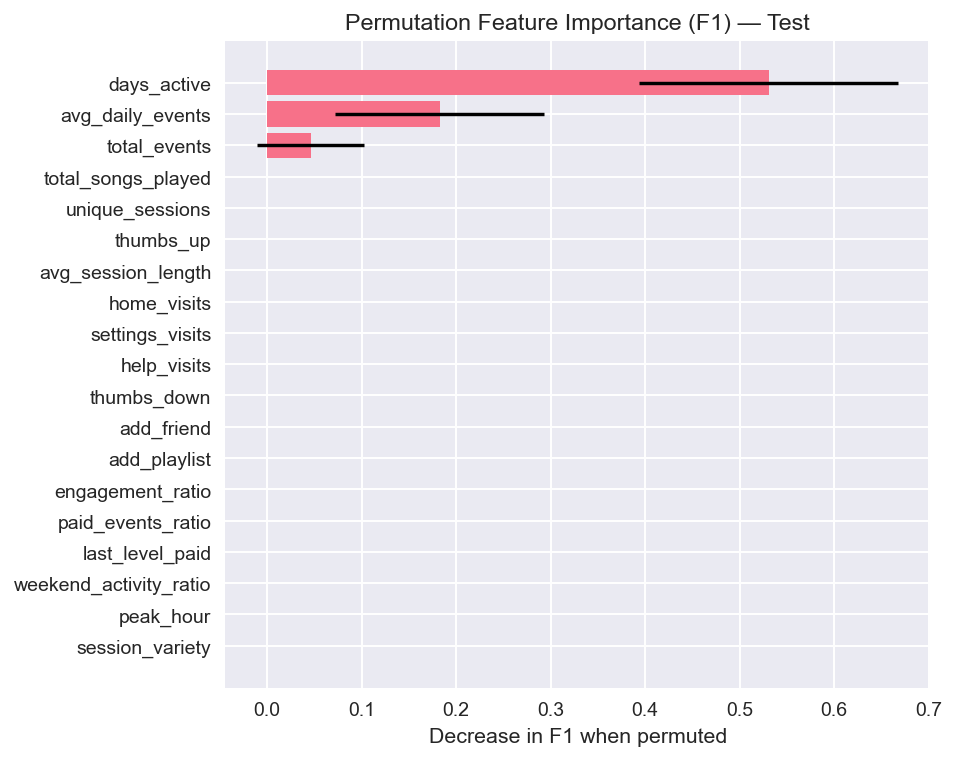


✅ Error analysis complete.


In [10]:


# ---------- Helpers ----------
def _ensure_proba(model, X):
    """Return positive class probabilities if available, else decision proxy."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        return proba[:, 1] if proba.ndim == 2 else proba.ravel()
    if hasattr(model, "decision_function"):
        # Map decision scores to [0,1] via rank-based scaling (diagnostic only)
        scores = model.decision_function(X).ravel()
        ranks = (scores - scores.min()) / (scores.ptp() + 1e-12)
        return ranks
    # Fallback: use predicted class as pseudo-proba
    return model.predict(X).astype(float)

def _plot_and_log(fig, name):
    """Show inline and log to MLflow if a run is active."""
    plt.show()
    try:
        mlflow.log_figure(fig, f"error_analysis/{name}.png")
    except Exception:
        pass

# ---------- Confusion Matrix & Report ----------
y_pred = final_model.predict(X_test)
fig, ax = plt.subplots(figsize=(5.0, 4.5), dpi=140)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("Confusion Matrix — Test")
_plot_and_log(fig, "confusion_matrix")
plt.close(fig)

print("Classification report (Test):")
print(classification_report(y_test, y_pred, digits=3))

# ---------- Threshold Sweep: PR & ROC ----------
y_score = _ensure_proba(final_model, X_test)

# Precision–Recall curve (binary) — useful for imbalanced churn
prec, rec, thr = precision_recall_curve(y_test, y_score)
fig, ax = plt.subplots(figsize=(5.0, 4.5), dpi=140)
ax.plot(rec, prec, lw=2)
ax.set_xlabel("Recall"); ax.set_ylabel("Precision"); ax.set_title("Precision–Recall (Test)")
ax.grid(True, ls="--", alpha=0.4)
_plot_and_log(fig, "precision_recall_curve")
plt.close(fig)

# ROC curve + AUC
fpr, tpr, roc_thr = roc_curve(y_test, y_score)
auc_val = roc_auc_score(y_test, y_score) if len(np.unique(y_test)) > 1 else np.nan
fig, ax = plt.subplots(figsize=(5.0, 4.5), dpi=140)
ax.plot(fpr, tpr, lw=2, label=f"AUC={auc_val:.3f}")
ax.plot([0,1],[0,1], ls="--", c="k", alpha=0.4)
ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.set_title("ROC (Test)")
ax.legend(); ax.grid(True, ls="--", alpha=0.4)
_plot_and_log(fig, "roc_curve")
plt.close(fig)

# Choose a threshold that maximizes F1 on TEST (or keep your VAL-tuned threshold)
best_idx = np.argmax(2 * (prec * rec) / (prec + rec + 1e-12))
best_thr = thr[max(0, best_idx - 1)] if len(thr) else 0.5  # guard when thr is empty
y_pred_opt = (y_score >= best_thr).astype(int)

print(f"\n▶ Suggested decision threshold from TEST PR curve: {best_thr:.3f}")
print(classification_report(y_test, y_pred_opt, digits=3))

# ---------- Calibration (Reliability Diagram) ----------
try:
    prob_true, prob_pred = calibration_curve(y_test, y_score, n_bins=10, strategy="quantile")
    fig, ax = plt.subplots(figsize=(5.0, 4.5), dpi=140)
    ax.plot([0,1],[0,1], "k--", alpha=0.6, label="Perfectly calibrated")
    ax.plot(prob_pred, prob_true, marker="o", lw=2, label="Model")
    ax.set_xlabel("Predicted probability"); ax.set_ylabel("True frequency")
    ax.set_title("Calibration curve (Reliability) — Test")
    ax.legend(); ax.grid(True, ls="--", alpha=0.4)
    _plot_and_log(fig, "calibration_curve")
    plt.close(fig)
except Exception as e:
    print(f"(Calibration skipped: {e})")

# ---------- Top Error Slices (simple, fast) ----------
# Show feature means where the model most often errs — helps find patterns quickly.
try:
    mis = (y_pred != y_test)
    if isinstance(X_test, pd.DataFrame):
        err_slice = (
            pd.concat([X_test.reset_index(drop=True), pd.Series(mis, name="error")], axis=1)
              .groupby("error").mean(numeric_only=True)
              .T.sort_values(by=True, ascending=False)[:15]
        )
        print("\nTop features correlated with errors (mean shift in error=True vs False):")
        display(err_slice.head(15))
except Exception as e:
    print(f"(Error-slice summary skipped: {e})")

# ---------- Permutation Feature Importance on TEST (optional, slow) ----------
# Robust to model type; reveals which features impact your chosen metric on TEST.
try:
    from sklearn.metrics import f1_score, make_scorer
    scorer = make_scorer(f1_score)
    pi = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42, scoring=scorer)
    if isinstance(X_test, pd.DataFrame):
        imp = (pd.DataFrame({
            "feature": X_test.columns,
            "importance_mean": pi.importances_mean,
            "importance_std":  pi.importances_std
        }).sort_values("importance_mean", ascending=False))
        print("\nPermutation importance (F1 on TEST):")
        display(imp.head(20))

        fig, ax = plt.subplots(figsize=(6.5, 6.0), dpi=140)
        topk = imp.head(20)[::-1]
        ax.barh(topk["feature"], topk["importance_mean"], xerr=topk["importance_std"])
        ax.set_title("Permutation Feature Importance (F1) — Test")
        ax.set_xlabel("Decrease in F1 when permuted")
        _plot_and_log(fig, "permutation_importance")
        plt.close(fig)
except Exception as e:
    print(f"(Permutation importance skipped: {e})")

print("\n✅ Error analysis complete.")
